# Convolutional neural networks for solving PDEs

> "Writing an iterative multigrid PDE solver as a convolutional neural network"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [neural networks]
- image: images/Covers/2021_06_17.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

PyTorch is mostly used as a high level library to setup and train neural networks, but it's actually very versatile. At its heart one can see it as a library to perform linear algebra and numerical optimization (with the help of automatic differentation). Beyond neural networks, those capabilities are also at the core of numerical simulations of physical processes. For the sake of it, I thought it would be fun to cast a numerical simulation as a neural network; plus we can take advantage of PyTorch's GPU computation.

## Physical problem

For the purpose of this example I will not be very original, and solve the classical diffusion equation.

$\frac{\partial T}{\partial t} = \frac{\partial }{\partial x} \kappa \frac{\partial T}{\partial x} + \frac{\partial }{\partial y} \kappa \frac{\partial T}{\partial y} + s,$ (1)

where $T$ is a physical quantity that diffuses or spreads out (e.g., temperature, smoke density, etc...). $\kappa$ is diffusivity. The larger $\kappa$ is, the faster $T$ diffuses. $s$ is a source or sink term, i.e., a quantity of $T$ that is added or subtracted at every small time $\Delta t$. To make things a bit more interesting we're going to solve the steady state problem:

$\frac{\partial }{\partial x} \kappa \frac{\partial T}{\partial x} + \frac{\partial }{\partial y} \kappa \frac{\partial T}{\partial y} + s = 0$ (2)

## Numerical approximation

Finite difference is a numerical simulation technique that is conceptually very simple, yet very powerful. The definition of a derivative of T with respect to x is:

$\frac{d T}{d x} = \lim_{\Delta x\to0} \frac {T(x+\Delta_x) - T(x)}{\Delta x} $ (3)

Well, to get a first order finite difference approximation of that derivative you simply remove the limit, but use a small enough value of $\Delta x$. What is small enough depends on the numerical solution method you are using. Also, since $\Delta x$ is not infinitely small, it is better to recenter the definition of limit to get more accurate solution at position x, which gives:

$\frac{d T}{d x} \approx \frac {T \big(x+\frac{\Delta_x}{2}\big) - T \big(x - \frac{\Delta_x}{2} \big)}{\Delta x}$ (4)

Thus, for the second order derivative in our diffusion equation we have the following:

$\frac{\partial }{\partial x} \kappa \frac{\partial T}{\partial x} \approx   \frac {\kappa \frac{\partial T}{\partial x} \big(x+\frac{\Delta_x}{2}\big) -  \kappa \frac{\partial T}{\partial x} \big(x - \frac{\Delta_x}{2} \big)}{\Delta x}, or$ (5)

$\frac{\partial }{\partial x} \kappa \frac{\partial T}{\partial x} \approx  \kappa (x + \frac{\Delta}{2}) \frac{T (x+\Delta x) - T (x)}{\Delta x^2} - \kappa (x - \frac{\Delta}{2}) \frac{T (x) - T (x-\Delta x)}{\Delta x^2} $ (6)


Now, consider that you have a grid with discrete values of T, all you need to compute to compute the derivatives is to add the values of neighbors weighted appropriately. In other terms, a finite difference approximation is a convolution operation. Therefore, we can build our solver as a convolutional network.

## Solution strategy

To solve the steady state problem, eq. (2), we will:
1. select an initial temperature distribution (input)
1. run the model forward to compute the solution of the equation (output). Most likely the solution won't be zero and we will need run optimization steps in order to make it zero.
1. Perform backward propagation and adjust the temperate
1. Repeat steps 2 and 3 until we've reached a solution close enough to zero.

In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from torch import nn
import torch.nn.functional as F
from time import time
import contextlib
from matplotlib import animation
from IPython.display import HTML

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

# Neural net solver class

Now, let's build the finite-difference solver using convolutions. We will solve the problem in 2D. First, we define a 2D matrix for T and store as an instance of `nn.Parameter` (which by default as the attribute `requires_grad=True`). T is the only parameter that needs to be optimized. The convolution kernel for first finite-difference is: `[[-1, 1]]` in direction x, and `[[1],[-1]]` in direction y. To get `\kappa (x + \frac{\Delta}{2})` we average in x or y, i.e. we convolve with kernel `[[.5, .5]]` in x, and `[[.5],[.5]]` in y. Since the kernels don't need to be optimized they are simply stored as `torch.tensor` with `requires_grad=False`.

To deal with boundary conditions we need to pad the solution, but the padding function provided by PyTorch only allow 0 padding or mirror, etc... To be able to assign arbitrary boundary conditions we do the padding manually. However, for simplicity, here, I will assing the values of T to be zero at the boundary (i.e. Dirichlet boundary condition).

In [2]:
class NeuralNetSolver(nn.Module):
    def __init__(self, T_ini, K, s, device='cpu'):
        super(NeuralNetSolver,self).__init__()
        self.nx = T_ini.shape[2]
        self.ny = T_ini.shape[3]
        self.T = nn.Parameter(T_ini[:,:,1:-1,1:-1])
        self.K = K.to(device)
        self.s = s.to(device)
        dx = 1./(self.nx-1)
        dy = 1./(self.ny-1)
        self.grad_x = torch.tensor([-1./dx, 1./dx]).reshape((1,1,2,1)).to(device)
        self.grad_y = torch.tensor([ 1./dy,-1./dy]).reshape((1,1,1,2)).to(device)
        
        self.avg_x = torch.tensor([.5,.5]).reshape((1,1,2,1)).to(device)
        self.avg_y = torch.tensor([.5,.5]).reshape((1,1,1,2)).to(device)
        
        self.BC_left = torch.zeros((1,1,self.nx-2,1)).to(device)
        self.BC_right = torch.zeros((1,1,self.nx-2,1)).to(device)
        
        self.BC_top = torch.zeros((1,1,1,self.ny)).to(device)
        self.BC_bot = torch.zeros((1,1,1,self.ny)).to(device)
        
    def forward(self):
        T = self.T
        K = self.K
        s = self.s
        
        # Add boundary conditions as padding
        T = self.pad_T()
        
        dT_dx = F.conv2d(T, self.grad_x)
        dT_dy = F.conv2d(T, self.grad_y)        
        
        K_avg_x = F.conv2d(K, self.avg_x)
        K_avg_y = F.conv2d(K, self.avg_y)
        
        K_d2T_dx2 = F.conv2d(K_avg_x*dT_dx, self.grad_x)
        K_d2T_dy2 = F.conv2d(K_avg_y*dT_dy, self.grad_y)

        return K_d2T_dx2[:,:,:,1:-1] + K_d2T_dy2[:,:,1:-1,:] + s[:,:,1:-1,1:-1]
        
    def pad_T(self):
        T = self.T
        T = torch.cat([self.BC_left, T, self.BC_right],dim=3)
        T = torch.cat([self.BC_bot, T, self.BC_top],dim=2)
        return T

# Loss function

We use the mean squared error between the computed solution and the expected solution (which is zero).

In [3]:
def loss_fn(y_hat):
    # note: expected outcome is 0
    return torch.mean((y_hat)**2)

# Training function

Nothing out of the ordinary here. The training function is a standard for neural networks and performs the following steps:

1. compute the solution
1. compute the loss
1. back propagate the loss
1. step the optimizer to update the values of the input parameter T
1. Print losses, etc...
1. Repeat 1 to 5 until the desired value is reached or until the optimization plateaus.



In [4]:
def train(net,loss_fn, optimizer, abs_loss_limit, rel_loss_limit, scheduler=None, n_iter=500, n_out=20):
    
    def closure():
        out = net()
        loss = loss_fn(out)
        optimizer.zero_grad()
        loss.backward()
        return loss
      
    last_loss = 0.0
    with timer("solve"):
        print(f"epoch  |  absolute loss  |  relative loss")
        print( "---------------------------------------------")
        for i in range(n_iter):
            loss = optimizer.step(closure)
            if scheduler:
                scheduler.step(loss)
            if (i%n_out)==0:
                with torch.no_grad():
                    loss = loss.item()
                    print(f" {i:04d}       {loss:.2e}          {abs(loss-last_loss):.2e}")
                if loss<abs_loss_limit:
                    print(f"Stop! absolute loss target reached ({abs_loss_limit:.2e})")
                    break
                elif abs(loss-last_loss)<rel_loss_limit:
                    print(f"Stop! relative loss target reached ({rel_loss_limit:.2e})")
                    break

                last_loss = loss
    
    return net.pad_T()


# Simple solver

Now, we initialize the input parameter T, as well as parameters K and s (not optimized). We instantiate our `NeuralnetSolver` and define an optimizer and stopping criterions. Then, we run the training function.

In [14]:
nx = 128
ny = 128
T_ini = torch.zeros((1,1,nx,ny))
K     = torch.ones((1,1,nx,ny))
s     = torch.ones((1,1,nx,ny))
net = NeuralNetSolver(T_ini, K,s)

optimizer = torch.optim.LBFGS(net.parameters())
abs_loss = 1e-10
rel_loss = 1e-100

T_padded = train(net, loss_fn, optimizer, abs_loss, rel_loss, n_out=50)

epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       1.00e+00          1.00e+00
 0050       6.70e-01          3.30e-01
 0100       5.55e-01          1.15e-01
 0150       9.50e-03          5.45e-01
 0200       3.96e-04          9.10e-03
 0250       2.32e-04          1.64e-04
 0300       2.25e-04          7.04e-06
 0350       2.21e-04          4.51e-06
 0400       2.12e-04          8.89e-06
 0450       6.01e-05          1.52e-04
solve: 34.21


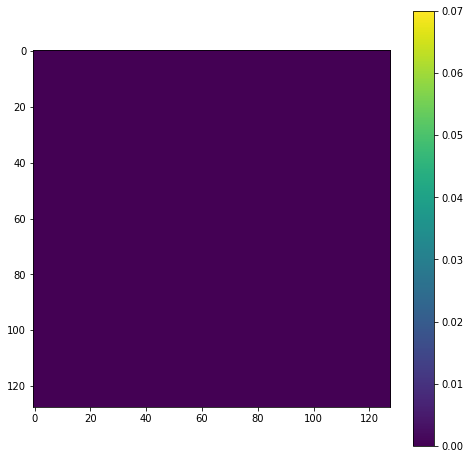

In [23]:
#hide
nx = 128
ny = 128
T_ini = torch.zeros((1,1,nx,ny))
K     = torch.ones((1,1,nx,ny))
s     = torch.ones((1,1,nx,ny))
net = NeuralNetSolver(T_ini, K,s)
optimizer = torch.optim.LBFGS(net.parameters())


def closure():
    out = net()
    loss = loss_fn(out)
    optimizer.zero_grad()
    loss.backward()
    return loss

def run_epoch(frame):
    # print(f"frame {frame:.0f}")
    for i in range(2):
        loss = optimizer.step(closure)

    with torch.no_grad():
        im_plot.set_data(net.pad_T()[0,0,:,:])
    return (im_plot,)

fig = plt.figure(figsize=[8,8])
with torch.no_grad():
    im_plot = plt.imshow(net.pad_T()[0,0,:,:],vmin=0.0, vmax=0.07)
    plt.colorbar()
anim = animation.FuncAnimation(fig, run_epoch, frames=80, interval=40)



In [ ]:
#hide_input
HTML(anim.to_html5_video())

# Multigrid solver

As one can see from the animation above the values of T are first updated towards the boundaries in a relatively small region (high freqency) and then slowly migrate towards the inside (i.e. updates low frequency features). It would be more efficient if we could get a rough update at low frequency (large regions) and then refine possible high frequency features. Also, one can clearly see that if we would start from an initial estimate of T that is close to the true solution, we get to solution much faster.

In a multigrid solver we successively solve the problem on grids of increasing resolution, using the results computed on the previous coarser grid as input for solving the next level. Thus, we can update the low frequency features on the coarser grid and successively add higher frequency. Also, only the coarsest grid level using a random initial guess. For all successive steps we have an initial guess for T that is not too far from the true solution. Thus, although we compute the solutions on several grids, the overall time to solution is lower than if we solved the fine grid with a random guess.

Typically, this technique becomes beneficial when the grid size becomes larger than 512x512. For the coarsest grid level it is advantageous to run on the cpu, but for grids larger than about 128x128, gpu computation is more advantageous.

In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:

n_level = 7 # each level reduces resolution by a factor two
coarse_res = 16
nx, ny = int(coarse_res/2*2**n_level), int(coarse_res/2*2**n_level)
print(nx, ny)
reduction_fac = [2**(n_level-1-level) for level in range(n_level)]
print(reduction_fac)
# Material properties should be defined on the finest grid
K_ref     = torch.ones((1,1,nx,ny))
s_ref     = torch.ones((1,1,nx,ny))

with timer('total'):
    for level, red_fac in enumerate(reduction_fac):
        

        n_iter = 10001
        n_out = 10
        if level<=3:
            device = 'cpu'
        else:
            device = 'cuda'
        if level<n_level-1:
            abs_loss = 1e-4
            rel_loss = 1e-12
            lr = 1.
        else:
            abs_loss = 1e-5
            rel_loss = 1e-7
            lr = 1.0#e-2
        
        with torch.no_grad():
            K = torch.nn.functional.avg_pool2d(K_ref, red_fac, stride=red_fac)
            s = torch.nn.functional.avg_pool2d(s_ref, red_fac, stride=red_fac)

        if level==0:
            T_ini = torch.zeros((1,1,int(nx/red_fac),int(ny/red_fac)))
        else:
            T_ini = F.interpolate(T_previous,scale_factor=2,mode='bilinear',align_corners=True)
        print(T_ini.shape)
        print(device)
                    

        net = NeuralNetSolver(T_ini, K,s,device).to(device)

        optimizer = torch.optim.LBFGS(net.parameters(),lr=lr)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=int(n_out/2))
        # scheduler = None
        # optimizer = torch.optim.Adam(net.parameters(), lr=5e-3/nx)
        

        
        T_previous = train(net, loss_fn, optimizer, abs_loss, rel_loss, scheduler, n_iter, n_out)

1024 1024
[64, 32, 16, 8, 4, 2, 1]
torch.Size([1, 1, 16, 16])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       1.00e+00          1.00e+00
 0010       4.65e-10          1.00e+00
Stop! absolute loss target reached (1.00e-04)
solve: 0.07
torch.Size([1, 1, 32, 32])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.22e-01          3.22e-01
 0010       1.01e-06          3.22e-01
Stop! absolute loss target reached (1.00e-04)
solve: 0.47
torch.Size([1, 1, 64, 64])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.26e-01          3.26e-01
 0010       1.35e-05          3.26e-01
Stop! absolute loss target reached (1.00e-04)
solve: 0.55
torch.Size([1, 1, 128, 128])
cpu
epoch  |  absolute loss  |  relative loss
---------------------------------------------
 0000       3.28e-01          3.28e-01
 0010       2.26e-05          3.28e-01
S

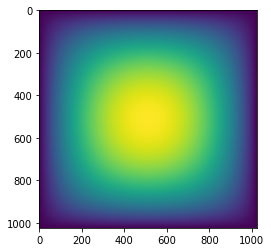

In [10]:
with torch.no_grad():
    plt.imshow(T_previous.to('cpu')[0,0,:,:])

# Conclusion

In this post, I showed you how to solve steady-state partial differential equations as a finite-difference iterative solver, and to write this solver as a convolutional neural network. We also saw how to improve the performance of the solver for large grid size by using multigrid computation. However, this solver is still relatively slow. Actually, at relatively low resolution (e.g. 2D problems up to 2048*2048) the fastest method is to build a sparse system of equation and solve it using a direct solver (i.e. gaussian elimiation with tricks). Another inconvenient of iterative solution method as we can see here or in neural networks is that the solver requires a lot of problem specific hyperparameter tweaking. Hence, it is not very robust and may get stuck in local minima. Here, I did not extensively tweak the hyperparameters and the solution is very far from machine precision. However, iterative solvers become interesting for large problems such as 3D numerical simulations or neural networks because they are more memory efficient and eventually perform faster than direct methods. Hence, iterative methods are an important tool for scientists.